# **TRAFICC FORECASTING**

## **1. GET DATA**

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import holidays
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf

In [3]:
df= pd.read_csv('Forecasting/Data/Traffic_data.csv')
df= df[['Time','Sensor548']]
df.columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17545 entries, 0 to 17544
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Time       17544 non-null  object
 1   Sensor548  17545 non-null  object
dtypes: object(2)
memory usage: 274.3+ KB


## **2. DATA CLEANING AND FEATURING**

In [4]:
df.dtypes

Time         object
Sensor548    object
dtype: object

In [5]:
df['Time']=pd.to_datetime(df['Time'], format='%d/%m/%Y %H:%M', errors='coerce')
df=df.dropna(subset=['Time']).sort_values('Time').set_index('Time')
assert df.index.duplicated().sum()==0

In [6]:
df['Sensor548']=pd.to_numeric(df['Sensor548'],errors='coerce')
df=df.dropna(subset=['Sensor548'])

In [7]:
df['Hour']=df.index.hour
df['Day']=df.index.day
df['DayOfWeek']=df.index.dayofweek
df['Month']=df.index.month
df['Year']=df.index.year
df['IsWeekend']=df['DayOfWeek'].isin([5,6]).astype(int)

us_holidays=holidays.US(state='CA')
df['IsHoliday'] = pd.Series(df.index.date).isin(us_holidays).astype(int).values


def get_season(month):
    if month in [12,1,2]:
        return 'Winter'
    elif month in [3,4,5]:
        return 'Spring'
    elif month in [6,7,8]:
        return 'Summer'
    else:
        return 'Autumn'

df['Season']=df['Month'].apply(get_season)

In [8]:
expected_index=pd.date_range(start=df.index.min(),end=df.index.max(),freq='H')
missing_timestamps=expected_index.difference(df.index)
print(f'Missing timestamps: {len(missing_timestamps)}')

Missing timestamps: 0


/var/folders/_z/vq1q1pzj639b28jbhlxzd0zw0000gn/T/ipykernel_9479/4287269602.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  expected_index=pd.date_range(start=df.index.min(),end=df.index.max(),freq='H')


In [9]:
df['Sensor548'].isna().sum()

np.int64(0)

## **3. EDA: Exploratory Data Analysis**

In [10]:
df['Sensor548'].describe()

count    17544.000000
mean         0.034855
std          0.020787
min          0.000000
25%          0.016200
50%          0.038900
75%          0.049200
max          0.514200
Name: Sensor548, dtype: float64

<Axes: title={'center': 'Sensor548 - Full Time Series'}, xlabel='Time'>

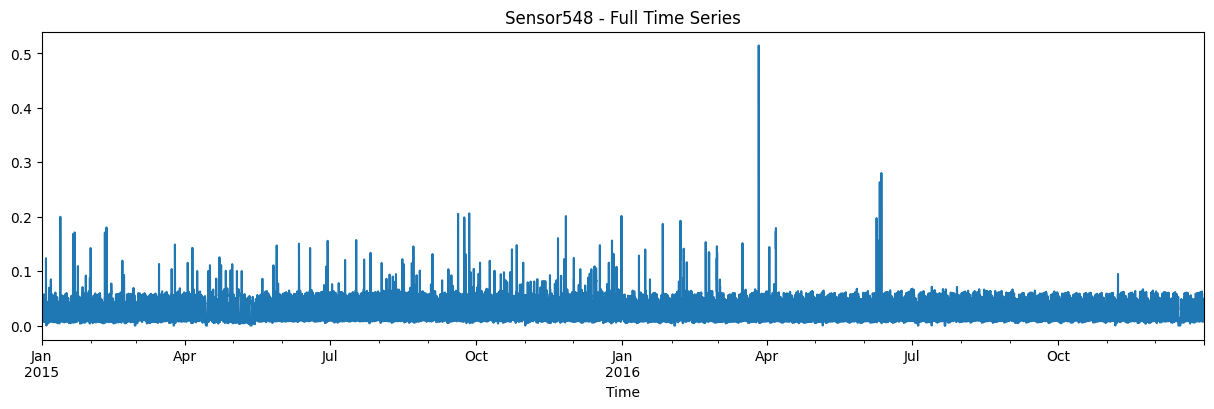

In [11]:
df['Sensor548'].plot(figsize=(15,4),title='Sensor548 - Full Time Series')

<Axes: title={'center': 'Avg Traffic by Hour'}, xlabel='Hour'>

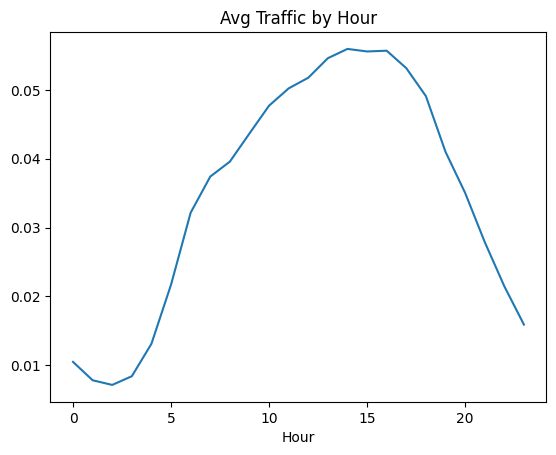

In [12]:
df.groupby('Hour')['Sensor548'].mean().plot(title='Avg Traffic by Hour')

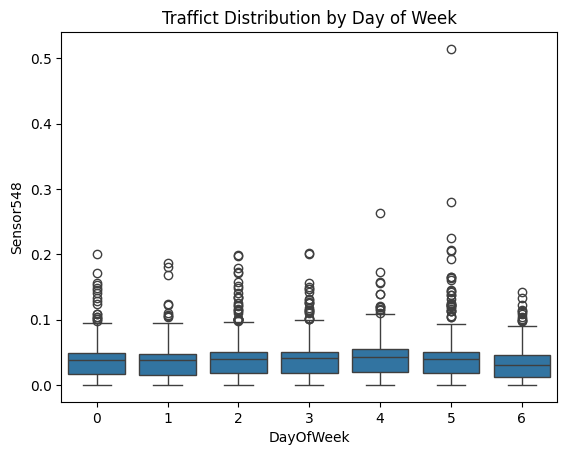

In [13]:
sns.boxplot(x='DayOfWeek',y='Sensor548',data=df.reset_index())
plt.title("Traffict Distribution by Day of Week")
plt.show()

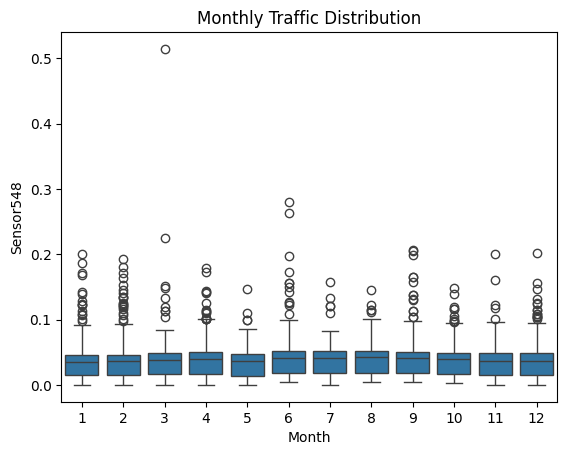

In [14]:
sns.boxplot(x='Month',y='Sensor548', data=df.reset_index())
plt.title('Monthly Traffic Distribution')
plt.show()

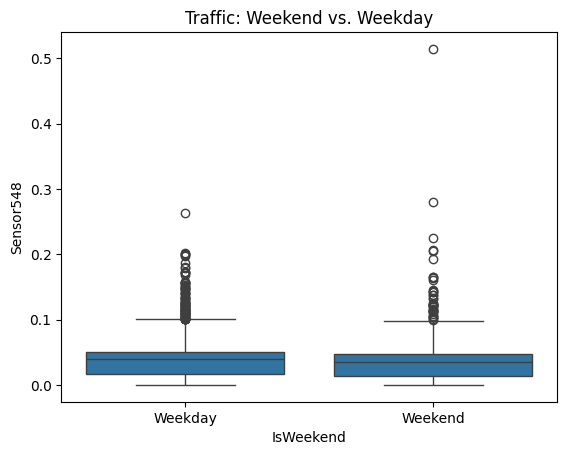

In [15]:
sns.boxplot(x='IsWeekend',y='Sensor548',data=df.reset_index())
plt.title('Traffic: Weekend vs. Weekday')
plt.xticks([0,1],['Weekday','Weekend'])
plt.show()

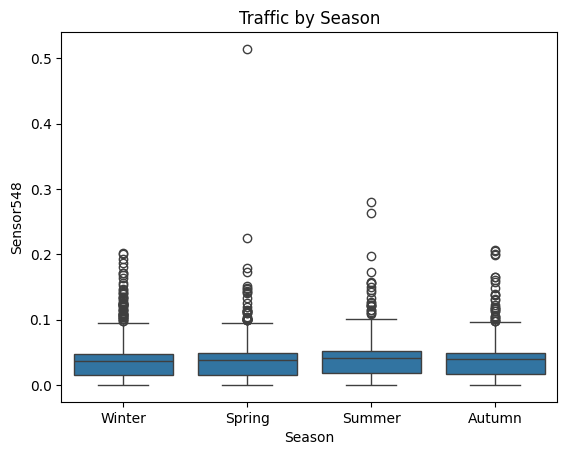

In [16]:
sns.boxplot(x='Season',y='Sensor548',data=df.reset_index())
plt.title('Traffic by Season')
plt.show()

<Axes: title={'center': 'Monthly Avg Traffic by Year'}, xlabel='Time'>

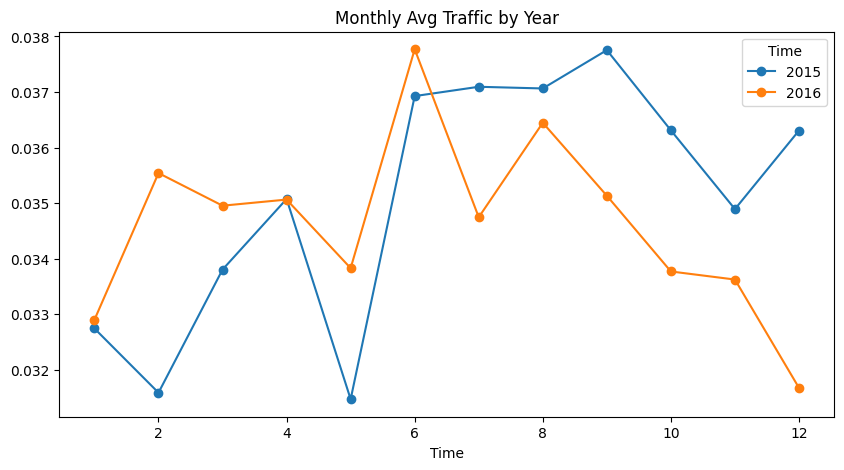

In [17]:
df.groupby([df.index.year, df.index.month])['Sensor548'].mean().unstack(0).plot(marker='o',figsize=(10,5),title='Monthly Avg Traffic by Year')

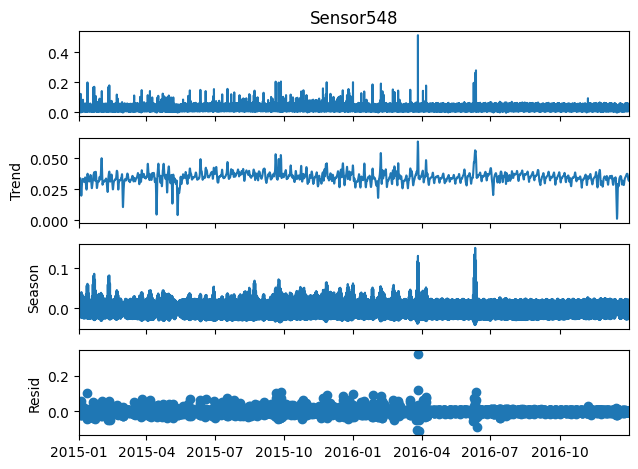

In [18]:
stl=STL(df['Sensor548'],period=24)
res=stl.fit()
res.plot()
plt.show()

In [19]:
df[['Sensor548','Hour','DayOfWeek','Month']].corr()

,Sensor548,Hour,DayOfWeek,Month
Sensor548,1.000000,3.797671e-01,-1.882202e-02,2.383102e-02
Hour,0.379767,1.000000e+00,2.054870e-17,6.311988e-16
DayOfWeek,-0.018822,2.054870e-17,1.000000e+00,-6.066774e-03
Month,0.023831,6.311988e-16,-6.066774e-03,1.000000e+00


## **4. MODEL PREPARATION**

Identify stationarity:

In [20]:
adf_result=adfuller(df['Sensor548'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -16.28917170724482
p-value: 3.351761132562199e-29


Generation of the ACF plot and PACF plot which help throughout the process of fitting Arima Models.

* AFC (Autocorrelation Function): Correlation of the time series with its lags. It measures the linear relationship between lagged values of the time series.
* PACF (Partial Autocorrelation Function): Is the partial correlation of the time series with its lags, after removing the effect of lower-order lags between them.

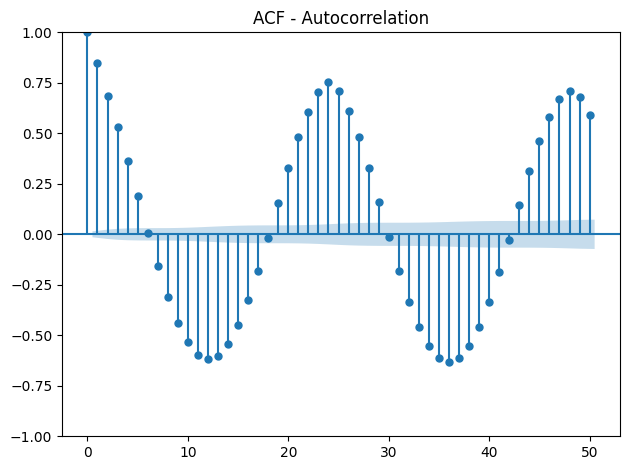

In [21]:
plot_acf(df['Sensor548'],lags=50)
plt.title('ACF - Autocorrelation')
plt.tight_layout()
plt.show()

High autocorrelation at lag 1, and then we find a repeating sinusiodal pattern. This indicates a seasonal structure, not a short-term moving average process. We must introduce seasonality.

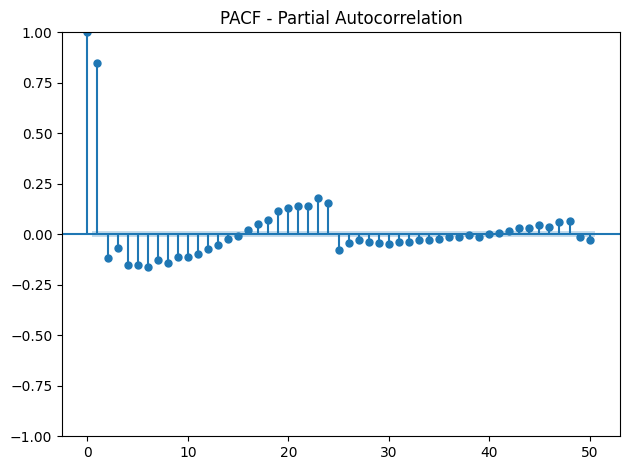

In [22]:
plot_pacf(df['Sensor548'],lags=50,method='ywm')
plt.title('PACF - Partial Autocorrelation')
plt.tight_layout()
plt.show()

There is a strong spike at lag 1, then rapid decay, after lag 2 there is not significant spikes. With this we consider a p=1.

In [23]:
df['Sensor548_seasonal_diff'] = df['Sensor548'] - df['Sensor548'].shift(24)
result_seasonal_adf = adfuller(df['Sensor548_seasonal_diff'].dropna())

print("ADF Statistic (Seasonal Differencing):", result_seasonal_adf[0])
print("p-value:", result_seasonal_adf[1])

ADF Statistic (Seasonal Differencing): -25.08352375392119
p-value: 0.0


The seasonal ADF test returned a statistic of –25.08 and a p-value of 0.0. With this result, we can conclude that the seasonally differenced series is stationary. This implies that the original series has non-stationary seasonality, and therefore, seasonal differencing is required. We set D = 1 in the SARIMA model.

Conclusions:

The model selected for this analysis is SARIMA(1, 0, 0) × (1, 1, 1, 24). The parameters are defined based on statistical tests and direct observation of the series’ behavior.

* Non-seasonal differencing (d = 0): The ADF test on the original series returned a statistic of –16.29 and a p-value below 0.05. This result confirms that the series is stationary without differencing.

* Seasonal differencing (D = 1): After differencing the series with a lag of 24, the ADF test yielded a statistic of –25.08 and a p-value of 0.0. This indicates that seasonal differencing is required to stabilize the seasonal component.

* Seasonal period (s = 24): The data is recorded hourly, and visual inspection confirmed a repeating daily pattern. A cycle of 24 hours is therefore appropriate.

* Autoregressive term (p = 1): The PACF plot showed a strong and isolated spike at lag 1, which supports the use of an AR(1) component.

* Moving average term (q = 0): The ACF plot did not show a clear cutoff at low lags, so no moving average term is included in the non-seasonal part of the model.

* Seasonal AR and MA terms (P = 1, Q = 1): Both ACF and PACF plots showed spikes at lag 24, consistent with daily seasonality. This supports the inclusion of one seasonal AR and one seasonal MA term.

## **5. MODELING**

Data split for modelling and testing:

In [24]:
print(df.index.min())
print(df.index.max())

2015-01-01 00:00:00
2016-12-31 23:00:00


In [25]:
train = df[df.index < '2016-12-01']
test = df[(df.index >= '2016-12-01') & (df.index <= '2016-12-31 23:00:00')]

In [26]:
print(len(test))
print(train.index.min(), test.index.max())

744
2015-01-01 00:00:00 2016-12-31 23:00:00


### 5.1. SARIMA MODEL (fixed)

#### MODEL 0

In [34]:
model_0= SARIMAX(train['Sensor548'],
               order=(1,0,0),
               seasonal_order=(1,1,1,24),
               enforce_stationarity=False,
               enforce_invertibility=False)

model_fit_0=model_0.fit(disp=False)
print(model_fit_0.summary())

/Users/fernandacladeramelgar/Documents/2_Projects/ForecastingII/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/fernandacladeramelgar/Documents/2_Projects/ForecastingII/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                            Sensor548   No. Observations:                16800
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 24)   Log Likelihood               54655.496
Date:                              Wed, 21 May 2025   AIC                        -109302.991
Time:                                      22:29:17   BIC                        -109272.086
Sample:                                  01-01-2015   HQIC                       -109292.793
                                       - 11-30-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5811      0.001    488.491      0.000       0.579       0.583
ar.S.L24       0.13

In [40]:
forecast_0 = model_fit_0.forecast(steps=len(test))
rmse_0 = np.sqrt(mean_squared_error(test['Sensor548'], forecast_0))
print("Model 0 RMSE:", rmse_0)

Model 0 RMSE: 0.009553921781879677


#### MODEL 1:

Adding a moving average component (q=1) to see if capturing short-term error patterns improves the fit.

In [31]:
model_1 = SARIMAX(train['Sensor548'],
                  order=(1, 0, 1),
                  seasonal_order=(1, 1, 1, 24),
                  enforce_stationarity=False,
                  enforce_invertibility=False)
model_fit_1 = model_1.fit(disp=False)
print(model_fit_1.summary())

/Users/fernandacladeramelgar/Documents/2_Projects/ForecastingII/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/fernandacladeramelgar/Documents/2_Projects/ForecastingII/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                          Sensor548   No. Observations:                16800
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood               54666.221
Date:                            Wed, 21 May 2025   AIC                        -109322.441
Time:                                    22:10:26   BIC                        -109283.811
Sample:                                01-01-2015   HQIC                       -109309.693
                                     - 11-30-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5368      0.002    215.388      0.000       0.532       0.542
ma.L1          0.0689      0.003   

In [41]:
forecast_1 = model_fit_1.forecast(steps=len(test))
rmse_1 = np.sqrt(mean_squared_error(test['Sensor548'], forecast_1))
print("Model 1 RMSE:", rmse_1)


Model 1 RMSE: 0.009556441271981013


#### MODEL 2:

In [32]:
model_2 = SARIMAX(train['Sensor548'],
                  order=(1, 0, 1),
                  seasonal_order=(1, 1, 0, 24),
                  enforce_stationarity=False,
                  enforce_invertibility=False)
model_fit_2 = model_2.fit(disp=False)
print(model_fit_2.summary())

/Users/fernandacladeramelgar/Documents/2_Projects/ForecastingII/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/fernandacladeramelgar/Documents/2_Projects/ForecastingII/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                           Sensor548   No. Observations:                16800
Model:             SARIMAX(1, 0, 1)x(1, 1, [], 24)   Log Likelihood               51954.897
Date:                             Wed, 21 May 2025   AIC                        -103901.794
Time:                                     22:12:44   BIC                        -103870.889
Sample:                                 01-01-2015   HQIC                       -103891.596
                                      - 11-30-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5413      0.003    164.880      0.000       0.535       0.548
ma.L1          0.0402      

In [42]:
forecast_2 = model_fit_2.forecast(steps=len(test))
rmse_2 = np.sqrt(mean_squared_error(test['Sensor548'], forecast_2))
print("Model 2 RMSE:", rmse_2)

Model 2 RMSE: 0.010110572160652516


In [43]:
print("\nRMSE Summary:")
print(f"Model 0 (1,0,0)x(1,1,1,24): {rmse_0:.5f}")
print(f"Model 1 (1,0,1)x(1,1,1,24): {rmse_1:.5f}")
print(f"Model 2 (1,0,1)x(1,1,0,24): {rmse_2:.5f}")


RMSE Summary:
Model 0 (1,0,0)x(1,1,1,24): 0.00955
Model 1 (1,0,1)x(1,1,1,24): 0.00956
Model 2 (1,0,1)x(1,1,0,24): 0.01011


Residuals evaluation:

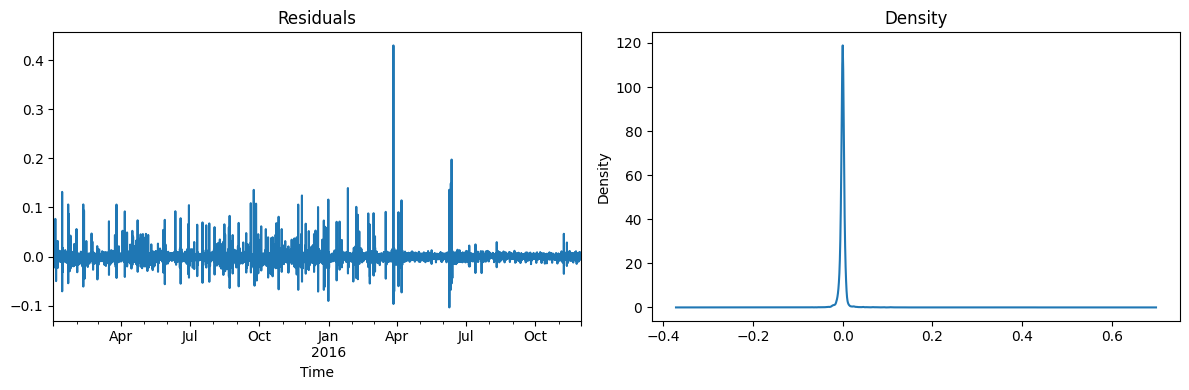

In [ ]:
residuals = model_fit_1.resid[1:]

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.tight_layout()
plt.show()

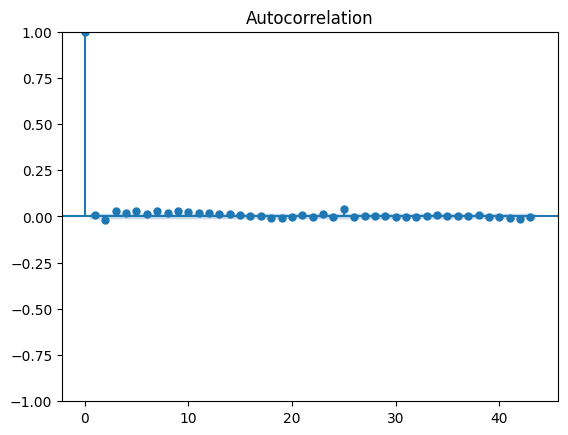

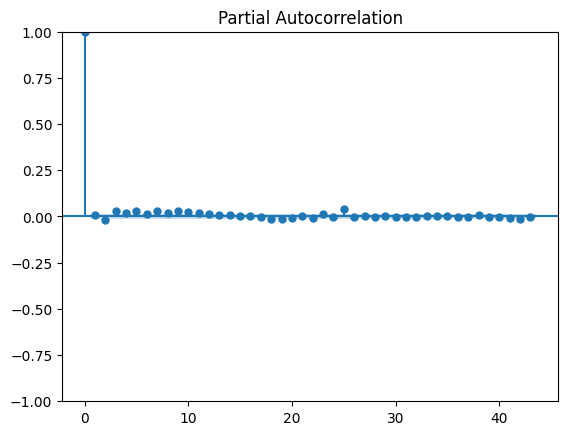

In [46]:
plot_acf(residuals)
plot_pacf(residuals)
plt.show()

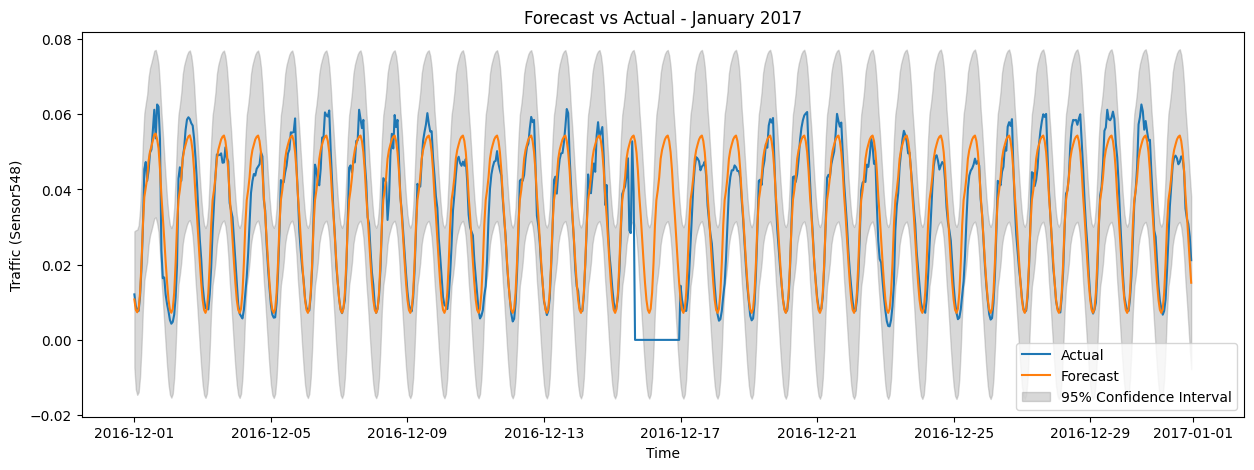

In [49]:
forecast_obj = model_fit_1.get_forecast(steps=len(test))
forecast_mean = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int(alpha=0.05)

plt.figure(figsize=(15, 5))
plt.plot(test.index, test['Sensor548'], label='Actual')
plt.plot(test.index, forecast_mean, label='Forecast')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='gray', alpha=0.3, label='95% Confidence Interval')
plt.title('Forecast vs Actual - January 2017')
plt.xlabel('Time')
plt.ylabel('Traffic (Sensor548)')
plt.legend()
plt.show()

/Users/fernandacladeramelgar/Documents/2_Projects/ForecastingII/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/fernandacladeramelgar/Documents/2_Projects/ForecastingII/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/fernandacladeramelgar/Documents/2_Projects/ForecastingII/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/_z/vq1q1pzj639b28jbhlxzd0zw0000gn/T/ipykernel_9479/186871729.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd

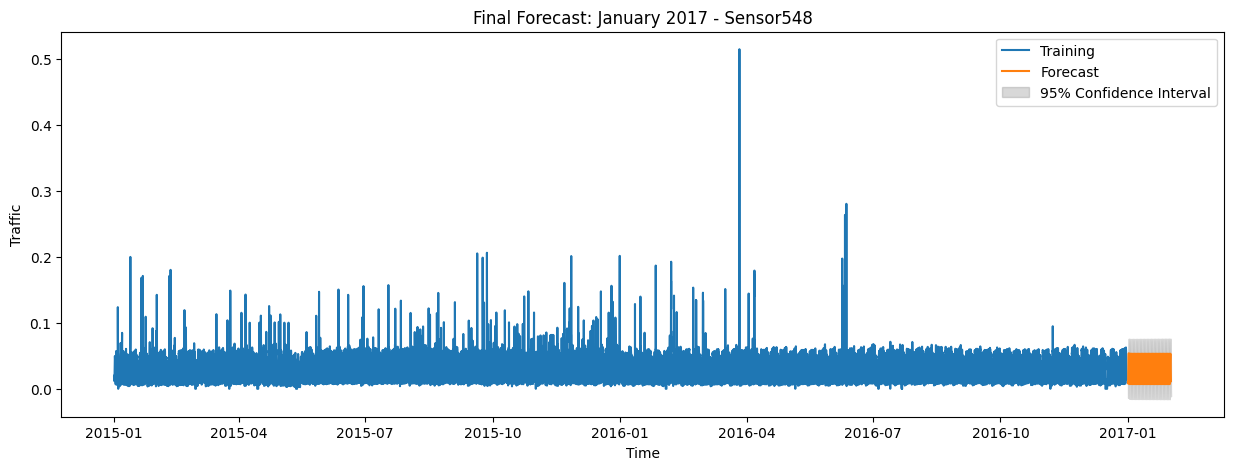

In [50]:
final_train = df[df.index <= '2016-12-31']

final_model = SARIMAX(final_train['Sensor548'],
                      order=(1, 0, 1),
                      seasonal_order=(1, 1, 1, 24),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
final_fit = final_model.fit(disp=False)

forecast_obj = final_fit.get_forecast(steps=744)
forecast_mean = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int(alpha=0.05)
forecast_index = pd.date_range(start='2017-01-01 00:00:00', periods=744, freq='H')

plt.figure(figsize=(15, 5))
plt.plot(final_train.index, final_train['Sensor548'], label='Training')
plt.plot(forecast_index, forecast_mean, label='Forecast')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='gray', alpha=0.3, label='95% Confidence Interval')
plt.title('Final Forecast: January 2017 - Sensor548')
plt.xlabel('Time')
plt.ylabel('Traffic')
plt.legend()
plt.show()

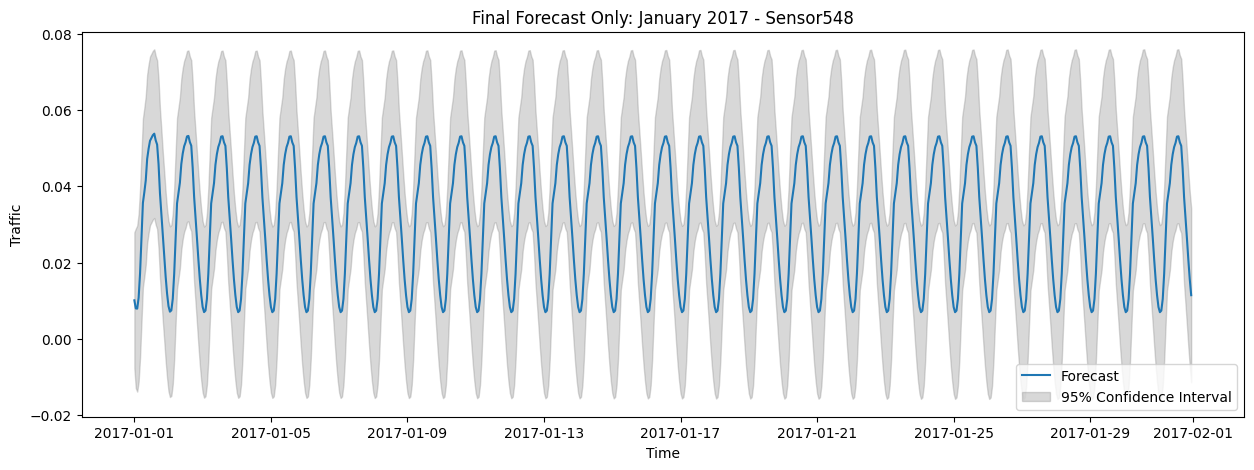

In [51]:
plt.figure(figsize=(15, 5))
plt.plot(forecast_index, forecast_mean, label='Forecast')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='gray', alpha=0.3, label='95% Confidence Interval')
plt.title('Final Forecast Only: January 2017 - Sensor548')
plt.xlabel('Time')
plt.ylabel('Traffic')
plt.legend()
plt.show()

In [55]:
def forecast_accuracy(forecast, actual):
    forecast = np.array(forecast)
    actual = np.array(actual)
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual))
    me = np.mean(forecast - actual)
    mae = np.mean(np.abs(forecast - actual))
    mpe = np.mean((forecast - actual) / actual)
    rmse = np.sqrt(np.mean((forecast - actual) ** 2))
    corr = np.corrcoef(forecast, actual)[0, 1]
    minmax = 1 - np.mean(np.minimum(forecast, actual) / np.maximum(forecast, actual))
    acf1 = acf(forecast - actual, nlags=1)[1]
    return {'mape': mape, 'me': me, 'mae': mae, 'mpe': mpe, 'rmse': rmse, 'acf1': acf1, 'corr': corr, 'minmax': minmax}

metrics = forecast_accuracy(forecast_mean, test['Sensor548'].values)
print("Forecast Accuracy Metrics:")
print(metrics)

Forecast Accuracy Metrics:
{'mape': np.float64(inf), 'me': np.float64(0.0009979261232832765), 'mae': np.float64(0.00727066713456258), 'mpe': np.float64(inf), 'rmse': np.float64(0.010557745726144702), 'acf1': np.float64(0.9059127968900003), 'corr': np.float64(0.8246268729334435), 'minmax': np.float64(0.23733793995836483)}


/var/folders/_z/vq1q1pzj639b28jbhlxzd0zw0000gn/T/ipykernel_9479/4058089111.py:4: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs(forecast - actual) / np.abs(actual))
/var/folders/_z/vq1q1pzj639b28jbhlxzd0zw0000gn/T/ipykernel_9479/4058089111.py:7: RuntimeWarning: divide by zero encountered in divide
  mpe = np.mean((forecast - actual) / actual)


In [ ]:
forecast_df = pd.DataFrame({
    'Datetime': forecast_index,
    'Forecast_Sensor548': forecast_mean.values
})


forecast_df.to_csv('forecast_jan_2017.csv', index=False)